### Analysis of dyad symmetries in centromeric and noncentromeric regions

Compare dyads detected using EMBOSS palindrome

In [12]:
from __future__ import division
%pylab inline
import glob
import seaborn as sns
import matplotlib.ticker as ticker
import re
sns.set_style('ticks')
sns.set_context('paper')
from scipy.stats import ks_2samp

def iter_palindrome(fn):
    """Generator -- parse EMBOSS palindrome output"""
    with open(fn,'r') as f:
        coords = []
        seqs = []
        name = None
        out = False

        for line in f:
            line = line.rstrip()
            if 'Palindromes of' in line:
                name = line.split()[2]
            elif ':' in line or len(line) == 0:
                continue
            else:
                if '|' in line:
                    nm = line.count('|')
                    out = True
                    continue
                else:
                    line = line.split()
                    s,e = int(line[0]),int(line[-1])
                    if s > e:
                        s,e = e,s
                    s -= 1
                    coords.append((s,e))
                    seqs.append(line[1].upper())
                    
                if out:
                    
                    G = coords[1][0]-coords[0][1]
                    
                    for (a,b),c in zip(coords,seqs):
                        yield name,a,b,c,nm/len(c),G
                        
                    out = False
                    coords = []
                    seqs = []
                    

def pal2mat(fn,minstem=5,maxstem=20,mingap=0,maxgap=20,pct_id=0.8,pidscale=False,norm=True):
    """Create a matrix of stem length x gap size from an EMBOSS palindrome file"""
    mat = np.zeros((maxstem-minstem+1,maxgap-mingap+1))
    
    nreads = 0
    for _,s,e,seq,pi,G in iter_palindrome(fn):
        nreads+=1
        L = len(seq)
        
        if (L < minstem or L > maxstem):
            continue
        if (G < mingap or G > maxgap):
            continue
        if pi < pct_id:
            continue
        
        if not pidscale:
            mat[L-minstem,G-mingap] += 1
        else:
            mat[L-minstem,G-mingap] += pct_id
    
    return mat, nreads

def parse_data(fns):
    """Parse EMBOSS palindorme data from a list of files; note that
    the length of the region must be encoded in the filename, for example:
    gi_30988105_gb_AACF01000002.1__43510_43710.emboss.txt"""
    data = []
    for fn in fns:
        sp = fn.split("_")
        L = int(sp[-1].split('.')[0]) - int(sp[-2])
        x = 0
        for name,s,e,seq,cvg,gap in iter_palindrome(fn):
            x += len(seq)
        data.append(x/L)
    return data

def format_horiz_bar(ax,data,labels,yticklabels=[0,1],xlabel=None,xlim=None,xticks=None,
                     colors=['black','white'],iqrscale=1.75):
    ml = ticker.MaxNLocator()
    ml._min_n_ticks=2
    ml._nbins=2
    ax.xaxis.set_major_locator(ml)
    
    mf = ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.xaxis.set_major_formatter(mf)
    
    bp = sns.boxplot(x=data,y=labels,ax=ax,palette=colors,fliersize=0,width=0.75,orient='h')
    
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        lnames = set(labels)
        
        upper = -np.inf
        
        for ln in lnames:
            subs = data[labels == ln]
            if len(subs) > 3:
                ql,qu = np.percentile(subs,q=[25,75])
                iqr = qu-ql
                lu = qu+iqrscale*iqr
            else:
                lu = np.max(data)
            if lu > upper:
                upper = lu
                
        ax.set_xlim(np.min(data),upper)
        
    plt.draw()
    
    if xlabel is not None:
        old_label = 'SIST score ()'
        try:
            units =  old_label[old_label.index("(") + 1:old_label.rindex(")")]
        except:
            units = ""
        label = old_label.replace("({})".format(units), "")
        exponent_text = ax.xaxis.get_offset_text().get_text().encode('utf-8')
        if len(exponent_text) > 1:
            exponent_text = re.sub("\xE2\x88\x92", "-", exponent_text)
            exponent_text.encode('ascii')
            exponent_text = exponent_text.replace("\\times", "")
            newlab = "{} ({} {})".format(label, exponent_text, units)
        else:
            newlab = xlabel
        ax.xaxis.set_label_text(newlab,size=10)
        ax.xaxis.offsetText.set_visible(False)
    
    ax.set_yticklabels(yticklabels,size=12)
    
    sns.despine(left=True,offset=5)
    ax.tick_params('y',length=0)
    ax.xaxis.set_tick_params(labelsize=10,length=4)

def format_vert_bar(ax,data,labels,xticklabels=[0,1],ylabel=None,ylim=None,yticks=None,
                     colors=['black','white'],iqrscale=1.75):
    ml = ticker.MaxNLocator()
    ml._min_n_ticks=2
    ml._nbins=2
    ax.yaxis.set_major_locator(ml)
    
    mf = ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(mf)
    
    bp = sns.boxplot(y=data,x=labels,ax=ax,palette=colors,fliersize=0,width=0.4,orient='v')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        lnames = set(labels)
        
        upper = -np.inf
        
        for ln in lnames:
            subs = data[labels == ln]
            if len(subs) > 3:
                ql,qu = np.percentile(subs,q=[25,75])
                iqr = qu-ql
                lu = qu+iqrscale*iqr
            else:
                lu = np.max(data)
            if lu > upper:
                upper = lu
                
        ax.set_ylim(np.min(data),upper)
        
    plt.draw()
    
    if yticks is not None:
        ax.set_yticks(yticks)
    
    
    if ylabel is not None:
        old_label = 'Score ()'
        try:
            units =  old_label[old_label.index("(") + 1:old_label.rindex(")")]
        except:
            units = ""
        label = old_label.replace("({})".format(units), "")
        exponent_text = ax.yaxis.get_offset_text().get_text().encode('utf-8')
        if len(exponent_text) > 1:
            exponent_text = re.sub("\xE2\x88\x92", "-", exponent_text)
            exponent_text.encode('ascii')
            exponent_text = exponent_text.replace("\\times", "")
            newlab = "{} ({} {})".format(label, exponent_text, units)
        else:
            newlab = ylabel
        ax.yaxis.set_label_text(newlab,size=9)
        ax.yaxis.offsetText.set_visible(False)
    
    ax.set_xticklabels(xticklabels,size=10)
    
    sns.despine(bottom=True,offset=5)
    ax.tick_params('x',length=0)
    ax.yaxis.set_tick_params(labelsize=9,length=4)
    
# Define colors:
blue = '#1f78b4'
brown = '#b15928'
gray = '#d9d9d9'
dark_gray = '#252525'
# dark_gray = '#d9d9d9'
# gray = 'white'

Populating the interactive namespace from numpy and matplotlib


#### Plot human cen vs. random

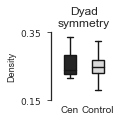

In [16]:
hue = []
data = []
names = []
minl = 0

fns = glob.glob('../data/palindrome/human/bacs/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/human/matched_random/*.txt')    
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))

plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
# format_horiz_bar(ax,data,names,yticklabels=['Cen','Control'],colors=colors,xlabel='Dyad density',xlim=(0.15,0.35))
format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],colors=colors,ylabel='Density',
                ylim=(0.15,0.35),yticks=[0.15,0.35])



ax.set_title('Dyad\nsymmetry',size=12)
plt.savefig('../figures/human_cen_dyad_symmetry.svg')
    

#### Plot human neocen vs. random

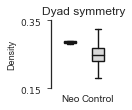

In [14]:
hue = []
data = []
names = []
minl = 0

fns = glob.glob('../data/palindrome/human/neocen/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Neo']*len(sdata))

fns = glob.glob('../data/palindrome/human/matched_random/*.txt')    
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))

plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
format_vert_bar(ax,data,names,xticklabels=['Neo','Control'],colors=colors,ylabel='Density',
                ylim=(0.15,0.35),yticks=(0.15,0.35))

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/human_neocen_dyad_density.svg')
    

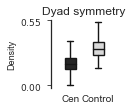

In [8]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/mouse/misat/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/mouse/misat_matched_random/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))


plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],
                 colors=colors,ylabel='Density',ylim=(-0.025,0.55),yticks=(0,0.55))

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/mouse_dyad_symmetry.svg')

#### Plot chicken cen vs. random

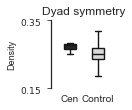

In [9]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/chicken/unique_cen/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/chicken/matched_random/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))


plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],
                 colors=colors,ylabel='Density',ylim=(0.15,0.35),yticks=(0.15,0.35))

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/chicken_dyad_symmetry.svg')

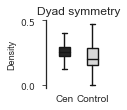

In [14]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/agm/cen/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/agm/random/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))


plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],
                 colors=colors,ylabel='Density',ylim=(-0.025,0.5),yticks=(0,0.5))

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/agm_dyad_symmetry.svg')

In [17]:
data = np.array(data)
names = np.array(names)
ks_2samp(data[names=='Cen'],data[names=='Control'])

Ks_2sampResult(statistic=0.19514285714285706, pvalue=0.62821232025532081)

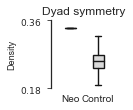

In [22]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/chicken/neocen/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Neo']*len(sdata))

fns = glob.glob('../data/palindrome/chicken/matched_random/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))


plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
format_vert_bar(ax,data,names,xticklabels=['Neo','Control'],colors=colors,
                 ylabel='Density',ylim=[0.18,0.36],yticks=[0.18,0.36])

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/chicken_neocen_dyad_symmetry.svg')

#### Cerevisiae

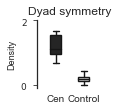

In [27]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/sacCer2/sacCer2'+'_cen/*.txt')

sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/sacCer2/sacCer2'+'_random/*.txt')

sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))

plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
# format_horiz_bar(ax,data,names,yticklabels=['Cen','Control'],colors=colors,xlabel='Dyad density',xlim=[0,2])

format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],colors=colors,
                 ylabel='Density',ylim=[-0.1,2],yticks=[0,2])

ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/sc2_dyad_density.svg')

In [7]:
names = []
hue = []
data = []
species = ['sacCer2','sacMik','sacKud','sacCas','sacDar']

for spec in species:
    fns = glob.glob('../data/palindrome/'+spec+ '/' + spec + '_random/*.txt')
    
    sdata = parse_data(fns)
    data.extend(sdata)
    hue.extend([0]*len(sdata))
    names.extend([spec]*len(sdata))
    
    fns = glob.glob('../data/palindrome/'+spec+ '/' + spec + '_cen/*.txt')
    sdata = parse_data(fns)
    data.extend(sdata)
    hue.extend([1]*len(sdata))
    names.extend([spec]*len(sdata))

In [2]:
names = []
hue = []
data = []
species=['sacCer2','sacMik','sacKud','sacCas','sacDar']

for spec in species:
#     if spec == 'None':
#         names.append(spec)
#         hue.append('cen')
#         data.append(None)
#         continue
        
    fns = glob.glob('../data/palindrome/'+spec+ '/' + spec + '_random/*.txt')
    for fn in fns:
        sp = fn.split("_")
        L = int(sp[-1].split('.')[0]) - int(sp[-2])
        x = 0
        for name,s,e,seq,cvg,gap in iter_palindrome(fn):
            x += len(seq)
        data.append(x/L)
        hue.append(0)
        names.append(spec)
    
    fns = glob.glob('../data/palindrome/'+spec+ '/' + spec + '_cen/*.txt')
        
    for fn in fns:
        sp = fn.split("_")
        L = int(sp[-1].split('.')[0]) - int(sp[-2])
        x = 0
        for name,s,e,seq,cvg,gap in iter_palindrome(fn):
            x += len(seq)
        data.append(x/L)
        hue.append(1)
        names.append(spec)
        


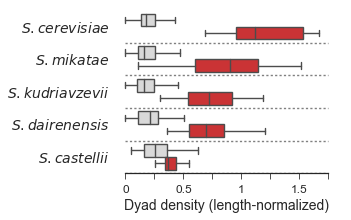

In [11]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

colors = ['#d9d9d9','#e31a1c']
sns.boxplot(x=data,y=names,hue=hue,palette=colors,fliersize=0)
# ax.set_xlim(-0.00001,0.0002)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2),size=10)
ax.set_yticklabels(['$\it{S. cerevisiae}$',
                    '$\it{S. mikatae}$',
                    '$\it{S. kudriavzevii}$',
                    '$\it{S. dairenensis}$',
                    '$\it{S. castellii}$'],size=14)
setp(ax.get_xticklabels(),size=12)
ax.axes.yaxis.set_tick_params(length=0)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.xaxis.set_ticklabels([0,'',0.5,'',1,'',1.5,''])
ax.legend_.remove()
ax.set_xlabel('Dyad density (length-normalized)',size=14)
ax.hlines([0.5,1.5,2.5,3.5,4.5],0,1.75,linestyles='dotted',colors='grey')
sns.despine(left=True,trim=True)

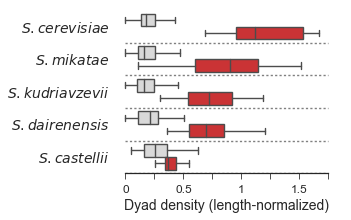

In [25]:
# # plt.figure(figsize=(2.5,4))
# plt.figure(figsize=(3,1.5))

# # color=['#e31a1c','black']
# sns.boxplot(x=data,y=names,hue=hue,
#               palette=['#e31a1c','grey'],fliersize=0,width=0.6)
# # setp(plt.legend(),visible=False)
# # plt.xticks([0.250,0.3,0.350],size=14)
# plt.xticks([0,0.75,1.5],size=14)
# plt.xlabel('Dyad density (length-normalized)',size=14)
# sns.despine(bottom=False,trim=True,left=True)
# plt.yticks([])
# # plt.savefig('figures/yeast_cen_dyad_density.svg')


fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

colors = ['#d9d9d9','#e31a1c']
sns.boxplot(x=data,y=names,hue=hue,palette=colors,fliersize=0)
# ax.set_xlim(-0.00001,0.0002)
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2),size=10)
ax.set_yticklabels(['$\it{S. cerevisiae}$',
                    '$\it{S. mikatae}$',
                    '$\it{S. kudriavzevii}$',
                    '$\it{S. dairenensis}$',
                    '$\it{S. castellii}$'],size=14)
setp(ax.get_xticklabels(),size=12)
ax.axes.yaxis.set_tick_params(length=0)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.xaxis.set_ticklabels([0,'',0.5,'',1,'',1.5,''])
ax.legend_.remove()
ax.set_xlabel('Dyad density (length-normalized)',size=14)
ax.hlines([0.5,1.5,2.5,3.5,4.5],0,1.75,linestyles='dotted',colors='grey')
sns.despine(left=True,trim=True)
plt.savefig('../figures/yeasts_dyad_density.svg')

([], <a list of 0 Text yticklabel objects>)

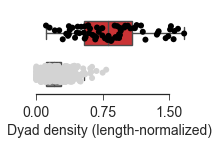

In [4]:
# plt.figure(figsize=(2.5,4))
plt.figure(figsize=(3,1.5))

# color=['#e31a1c','black']
sns.stripplot(x=data[::-1],y=hue[::-1],s=6,jitter=0.2,
              palette=['black','lightgrey'])
sns.boxplot(x=data[::-1],y=hue[::-1],
              palette=['#e31a1c','grey'],fliersize=0,width=0.6)
# setp(plt.legend(),visible=False)
# plt.xticks([0.250,0.3,0.350],size=14)
plt.xticks([0,0.75,1.5],size=14)
plt.xlabel('Dyad density (length-normalized)',size=14)
sns.despine(bottom=False,trim=True,left=True)
plt.yticks([])
# plt.savefig('figures/yeast_cen_dyad_density.svg')

In [3]:
names = []
hue = []
data = []
minl = 0


random = []
bac = []
neo = []


fns = glob.glob('../data/palindrome/human/matched_random/*.txt')
for fn in fns:
#     print fn
    x = 0
    
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
        
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        if len(seq) > minl:
            x += len(seq)
    data.append(x/L)
    hue.append('Random')
    names.append('human')
    
    random.append(x/L)
    
#     if x > 2500:
#         print fn


fns = glob.glob('../data/palindrome/human/bacs/*.txt')

for fn in fns:
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    
    x = 0
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        if len(seq) > minl:
            x += len(seq)
    data.append(x/L)
    hue.append(r'$\alpha$'+'-satellite')
    names.append('human')
    
    
    bac.append(x/L)

fns = glob.glob('../data/palindrome/human/neocen/*.txt')

for fn in fns:
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    x = 0
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        if len(seq) > minl:
            x += len(seq)
    data.append(x/L)
    hue.append('Neocentromere')
    names.append('human')
    
    neo.append(x/L)
    




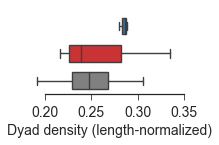

In [4]:
# plt.figure(figsize=(2.5,4))
plt.figure(figsize=(3,1.5))

# color=['#e31a1c','black']
# sns.stripplot(x=data[::-1],y=hue[::-1],s=6,jitter=0.2,
#               palette=['black','lightgrey'])
sns.boxplot(x=data[::-1],y=hue[::-1],
              palette=['#1f78b4','#e31a1c','grey'],fliersize=0,width=0.6,whis=1)
# setp(plt.legend(),visible=False)
# plt.xticks([0.250,0.3,0.350],size=14)
# plt.xticks([0,0.75,1.5],size=14)
plt.xlim(0.18,0.36)
plt.xticks(size=14)
plt.xlabel('Dyad density (length-normalized)',size=14)
sns.despine(bottom=False,trim=True,left=True)
plt.yticks([])
plt.savefig('../figures/human_neocen_cen_dyad_density.svg')

#### Pombe

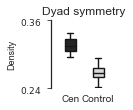

In [11]:
names = []
hue = []
data = []

fns = glob.glob('../data/palindrome/pombe/pombe_cen/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([1]*len(sdata))
names.extend(['Cen']*len(sdata))

fns = glob.glob('../data/palindrome/pombe/matched_random/*.txt')
sdata = parse_data(fns)
data.extend(sdata)
hue.extend([0]*len(sdata))
names.extend(['Control']*len(sdata))

plt.figure(figsize=(1,1.25))
ax = plt.subplot(111)

data = np.array(data)
names = np.array(names)
colors = [dark_gray,gray]
# format_horiz_bar(ax,data,names,yticklabels=['Cen','Control'],colors=colors,xlabel='Dyad density',xlim=[0.24,0.36])
format_vert_bar(ax,data,names,xticklabels=['Cen','Control'],colors=colors,ylabel='Density',
                ylim=(0.24,0.36),yticks=[0.24,0.36])
ax.set_title('Dyad symmetry',size=12)
plt.savefig('../figures/pombe_cen_dyad_density.svg')

In [11]:
names = []
hue = []
data = []

random = []
cen = []


fns = glob.glob('../data/palindrome/pombe/matched_random/*.txt')
for fn in fns:
#     print fn
    x = 0
    
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        x += len(seq)
    data.append(x/L)
    hue.append('Random')
    names.append('pombe')
    
    random.append(x/L)
    
#     if x > 2500:
#         print fn


fns = glob.glob('../data/palindrome/pombe/pombe_cen/*.txt')

for fn in fns:
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    
    x = 0
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        x += len(seq)
    data.append(x/L)
    hue.append('cen')
    names.append('pombe')
    
    cen.append(x/L)



In [12]:
ks_2samp(random,cen)

Ks_2sampResult(statistic=0.95679012345679015, pvalue=0.0026888151507499449)

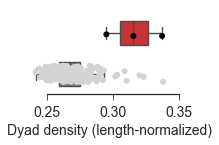

In [75]:
# plt.figure(figsize=(2.5,4))
plt.figure(figsize=(3,1.5))

# color=['#e31a1c','black']
sns.stripplot(x=data[::-1],y=hue[::-1],s=6,jitter=0.2,
              palette=['black','lightgrey'])
sns.boxplot(x=data[::-1],y=hue[::-1],
              palette=['#e31a1c','grey'],fliersize=0,width=0.6)
# setp(plt.legend(),visible=False)
plt.xticks([0.250,0.3,0.350],size=14)
plt.xlabel('Dyad density (length-normalized)',size=14)
sns.despine(bottom=False,trim=True,left=True)
plt.yticks([])
plt.savefig('../figures/pombe_cen_dyad_density.svg')

In [2]:
names = []
hue = []
data = []

random = []
unique = []
neo = []


fns = glob.glob('../data/palindrome/chicken/matched_random/*.txt')
for fn in fns:
#     print fn
    x = 0
    
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        x += len(seq)
    data.append(x/L)
    hue.append('Random')
    names.append('chicken')
    
    random.append(x/L)
    
#     if x > 2500:
#         print fn


fns = glob.glob('../data/palindrome/chicken/unique_cen/*.txt')

for fn in fns:
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    
    x = 0
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        x += len(seq)
    data.append(x/L)
    hue.append(r'$\alpha$'+'-satellite')
    names.append('chicken')
    
    unique.append(x/L)
    

fns = glob.glob('../data/palindrome/chicken/neocen/*.txt')

for fn in fns:
    sp = fn.split("_")
    L = int(sp[-1].split('.')[0]) - int(sp[-2])
    x = 0
    for name,s,e,seq,cvg,gap in iter_palindrome(fn):
        x += len(seq)
    data.append(x/L)
    hue.append('Neocentromere')
    names.append('chicken')
    
    neo.append(x/L)




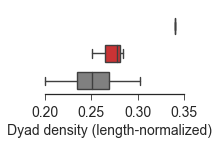

In [31]:
plt.figure(figsize=(3,1.5))
sns.boxplot(x=data[::-1],y=hue[::-1],
              palette=['#1f78b4','#e31a1c','grey'],fliersize=0,width=0.6,whis=1)
plt.xlim(0.18,0.36)
plt.xticks(size=14)
plt.xlabel('Dyad density (length-normalized)',size=14)
sns.despine(bottom=False,trim=True,left=True)
plt.yticks([])
plt.savefig('../figures/chicken_neocen_cen_dyad_density.svg')